# Imports and parameters

In [ ]:
import copy
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import average_precision_score
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm

%matplotlib inline


In [2]:
MODELS_FOLDER = "models_cnn"
DATA_FOLDER = r"D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data"

N_TRIALS = 50
BATCH_SIZE = 32

search_space = {
    # Model capacity
    "EPOCHS": [50, 100, 200, 300],
    "CONV_LAYERS": [3, 4, 5],
    "INITIAL_FILTERS": [8, 16, 32],
    "NUM_FC1": [64, 100, 128, 256],
    "DROPOUT_RATE": [0.10, 0.25, 0.35, 0.50],
    # "activation": ["relu", "leaky_relu", "silu"],
    # # Optimization
    # "optimizer": ["adamw", "sgd"],
    # "lr_adamw": [3e-4, 1e-3],
    # "lr_sgd": [1e-2, 5e-2, 1e-1],
    # "weight_decay": [1e-5, 1e-4, 3e-4],
    # "scheduler": ["cosine", "one_cycle"],
    # "batch_size": [16, 32, 64],
    # "grad_clip": [0.0, 1.0],  # 0.0 to disable
    # # Regularization and calibration
    # "label_smoothing": [0.0, 0.05, 0.10],
    # "mixup_alpha": [0.0, 0.2, 0.4],  # 0.0 to disable
    # "use_ema": [False, True],
    # "ema_decay": [0.999],  # only used if use_ema=True
    # # Input resolution (if you can resize)
    # "image_size": [46, 64, 96],  # update params['shape_in'] accordingly
    # # Loss options for 60/40 cancer detection
    # "loss": ["bce", "focal"],
    # "focal_gamma": [1.0, 2.0],  # only if loss == "focal"
    # # Threshold selection target (for validation tuning)
    # "threshold_target": ["max_f1", "recall_at_precision_90", "precision_at_recall_90"],
}


# Data name loading and visual inspection

In [3]:
full_data_labels_path = os.path.join(DATA_FOLDER, "full_data_labels.csv")
train_labels_path = os.path.join(DATA_FOLDER, "train_labels.csv")
val_labels_path = os.path.join(DATA_FOLDER, "val_labels.csv")
test_labels_path = os.path.join(DATA_FOLDER, "test_labels.csv")

In [4]:
full_data_df = pd.read_csv(full_data_labels_path)
# quick look at the label stats
full_data_df["label"].value_counts()

label
0    13091
1     8911
Name: count, dtype: int64

In [5]:
train_df = pd.read_csv(train_labels_path)
train_df

,id,label
0,854ed1a48d55f17b674cbb5a87bf41bf8dd51342,0
1,1b9b194b91ab720d2f1e4e2c1067680f98a4a434,1
2,f17b38d3a1480b51ff6558fedaa01899a612ade0,0
3,4f4e453db5316c09e99d909a48e66daebe81b660,0
4,9abd01816f80bf0668d6ec00bdc5c4f3e7b13e10,0
...,...,...
13195,e77a418b25cb2850ceff6fdbf93b4a457d0606a0,1
13196,dbaafb0fdd2d2601a29593bc7ab56a8535ace60c,1
13197,62345b879d48c243bfbf4dc50732e7ca84274dfb,0
13198,71ad737ba403a019655f65d3d340cde6b8410463,1


In [6]:
val_df = pd.read_csv(val_labels_path)
val_df

,id,label
0,ec9e436b7ca5b6aebd32ccc6311864a7fb7cf4c9,0
1,9098e467f8ee6af39b8a716d460dab9e5682cbad,0
2,3d1ff2625960b85db39fc9e4ae0ae6460f9e98f6,1
3,2d16f714f8d47349125b567e8f04b8dbe3d8e835,0
4,dcd9f31f61b392ad0a47a32bbcb01b20a2c7b152,1
...,...,...
4396,a7a428e60387fa6f88910317c15ebe1821723589,0
4397,6b92017850b7ec861bc61514a55da381d0b08a95,0
4398,4abc731c00e686af0151da626f795ec04c447979,0
4399,e90832b536fa2f292f8317214461d9d91b2cd7d4,1


In [7]:
test_df = pd.read_csv(test_labels_path)
test_df

,id,label
0,38277151862870436fcb4c0b592327c291d411b0,1
1,55eed9019b38016de3f87c1929b9e2765114f3b3,1
2,36b442b0b01a8df84fe246029e7bfdb2ed7efd1d,0
3,056046847c7e88dfea9c0a686e08a524e1df8503,0
4,30c0ef2b2a53098557772a21382524aa97d499f2,0
...,...,...
4396,d0d5b615c8ec33f40a3a0e6962b56e9c65ab5981,0
4397,2bcac4a39f1e365f8835b1bf4458ceba86e297d6,0
4398,1f839cbd88129b9e04151253a5999dae88b93b3b,1
4399,f11857e50f263ac565b630a76b47fb96d7b8198d,0


# Dataset for train and val

In [8]:
torch.manual_seed(0)  # fix random seed


class pytorch_data(Dataset):
    def __init__(self, data_folder, labels_df, transforms, mode="train"):
        # Get Image File Names
        mode_data_folder = os.path.join(data_folder, mode)

        file_names = [f"{idx}.tif" for idx in labels_df["id"]]

        self.full_filenames = [
            os.path.join(mode_data_folder, f) for f in file_names
        ]  # get the full path to images

        self.labels = labels_df["label"].tolist()
        self.transform = transforms

    def __len__(self):
        return len(self.full_filenames)  # size of dataset

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image)  # Apply Specific Transformation to Image
        return image, self.labels[idx]


In [9]:
# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose([transforms.ToTensor()])

In [10]:
train_ts = pytorch_data(DATA_FOLDER, train_df, data_transformer, mode="train")

In [11]:
val_ts = pytorch_data(DATA_FOLDER, val_df, data_transformer, mode="val")

In [12]:
# Training DataLoader
train_dl = DataLoader(train_ts, batch_size=BATCH_SIZE, shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# check samples
for x, y in train_dl:
    print(x.shape, y)
    break

torch.Size([32, 3, 96, 96]) tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1])


# Model creation

In [14]:
import torch  # Import PyTorch main package
import torch.nn.functional as F  # Import functional API from PyTorch for activation functions, etc.


class Network(nn.Module):  # Define a neural network class inheriting from nn.Module
    def __init__(self, params):  # Initialize the network with a params dictionary
        super(Network, self).__init__()  # Call constructor of parent nn.Module

        Cin, Hin, Win = params[
            "shape_in"
        ]  # Get input channels, height, width from params
        init_f = params[
            "initial_filters"
        ]  # Get the initial number of filters for the first conv layer
        num_fc1 = params[
            "num_fc1"
        ]  # Get number of units for the first FC (fully connected) layer
        num_classes = params["num_classes"]  # Get output classes for classification
        self.dropout_rate = params[
            "dropout_rate"
        ]  # Store dropout rate for regularization
        num_conv_layers = params.get(
            "conv_layers", 4
        )  # Get conv layers (default 4 if not specified)

        self.convs = (
            nn.ModuleList()
        )  # Initialize an empty ModuleList to hold sequential conv layers

        in_channels = Cin  # Set starting number of channels to input channels
        out_channels = init_f  # Set starting number of output channels

        for i in range(
            num_conv_layers
        ):  # Loop over the desired number of convolutional layers
            out_channels = init_f * (
                2**i
            )  # Double the number of channels every layer (wider as it goes deeper)
            conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, padding=1
            )  # Define a 2D convolution layer
            self.convs.append(conv)  # Add layer to the list
            in_channels = out_channels  # Update the in_channels for the next layer

        self.gap = nn.AdaptiveAvgPool2d(
            (1, 1)
        )  # Add Global Average Pooling to produce 1x1 spatial map per channel
        self.num_flatten = (
            out_channels  # Number of features after GAP is the number of channels
        )
        self.fc1 = nn.Linear(
            self.num_flatten, num_fc1
        )  # First fully connected layer (after flattening GAP output)
        self.fc2 = nn.Linear(
            num_fc1, num_classes
        )  # Final FC layer to produce class logits

    def forward(self, X):  # Define the forward pass of the network
        for i, conv in enumerate(self.convs):  # Iterate through convolutional layers
            X = F.relu(conv(X))  # Apply conv layer and ReLU activation
            # Optional: Apply max pooling unless it's the last conv layer or feature map is too small
            if i < len(self.convs) - 1 and min(X.shape[-2:]) > 2:
                X = F.max_pool2d(X, 2, 2)  # Downsample feature maps by 2x

        X = self.gap(
            X
        )  # Apply global average pooling (output shape: [batch, channels, 1, 1])
        X = torch.flatten(X, 1)  # Flatten except batch dimension ([batch, channels])
        X = F.relu(self.fc1(X))  # Apply the first fully connected layer and ReLU
        X = F.dropout(X, self.dropout_rate)  # Apply dropout for regularization
        X = self.fc2(X)  # Apply the final linear layer for class logits
        return F.log_softmax(
            X, dim=1
        )  # Return (log-)softmax probabilities over output classes


# Training functions

In [18]:
""" Helper Functions"""

from sklearn.metrics import f1_score

# The metric used in these helper functions is **F1 score**.
# For each batch, we collect the predicted probabilities for the positive class and the true target labels.
# At the end of the epoch, we compute the F1 score over the entire dataset.


# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]


# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)  # get loss

    # For F1, we need the predicted class labels and the true target labels
    if output.shape[1] == 1:
        # If output is shape (batch, 1), use sigmoid
        probs = torch.sigmoid(output).detach().cpu().numpy().flatten()
    else:
        # If output is shape (batch, 2), use softmax for class 1
        probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    targets_np = target.detach().cpu().numpy()
    try:
        metric_b = f1_score(targets_np, preds)
    except ValueError:
        # If only one class present in y_true, f1_score is not defined
        metric_b = None

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


# Compute the loss value & F1 score for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    run_loss = 0.0
    len_data = len(dataset_dl.dataset)

    all_probs = []
    all_targets = []

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, _ = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b

        # collect probs and targets for F1 computation
        if output.shape[1] == 1:
            probs = torch.sigmoid(output).detach().cpu().numpy().flatten()
        else:
            probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.detach().cpu().numpy())

    # epoch-level metrics
    loss = run_loss / float(len_data)
    probs_epoch = np.concatenate(all_probs, axis=0)
    targets_epoch = np.concatenate(all_targets, axis=0)

    preds_epoch = (probs_epoch >= 0.5).astype(int)
    try:
        f1 = f1_score(targets_epoch, preds_epoch)
    except ValueError:
        f1 = None

    return loss, f1

In [19]:
def train_val(model, params, verbose=False):
    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    model_name = params.get("model_name", "default_model")

    loss_history = {"train": [], "val": []}  # history of loss values in each epoch
    metric_history = {
        "train": [],
        "val": [],
    }  # history of metric values (f1 score) in each epoch

    # Best checkpoint tracking
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_metric = -float("inf")
    best_val_metric_epoch = -1
    best_loss = float("inf")
    best_loss_epoch = -1
    early_stop_patience = 15  # stop if val metric stalls by epoch 15

    """ Train Model n_epochs """

    for epoch in tqdm(range(epochs)):
        """ Get the Learning Rate """
        current_lr = get_lr(opt)
        if verbose:
            print("Epoch {}/{}, current lr={}".format(epoch, epochs - 1, current_lr))

        """
        Train Model Process
        """

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        """
        Evaluate Model Process
        """

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # Checkpoint selection: prefer F1 score, fallback to loss if F1 is None
        improved = False
        if val_metric is not None:
            if val_metric > best_val_metric:
                best_val_metric = val_metric
                best_val_metric_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                # store weights into a local file
                torch.save(model.state_dict(), weight_path)
                improved = True
                if verbose:
                    print("Copied best model weights (by F1 score)!")
        else:
            # fallback to loss if F1 is None
            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weight_path)
                improved = True
                if verbose:
                    print("Copied best model weights (by loss, F1 score is None)!")

        # learning rate schedule (always step on val_loss)
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if verbose:
            f1_str = f"{val_metric:.4f}" if val_metric is not None else "N/A"
            print(
                f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, F1 score: {f1_str}"
            )
            print("-" * 10)

        # Early stopping: if val F1 hasn't improved for 15 epochs, stop
        if val_metric is not None:
            if epoch - best_val_metric_epoch >= early_stop_patience:
                if verbose:
                    print(
                        f"Early stopping at epoch {epoch} due to no improvement in val F1 score for {early_stop_patience} epochs."
                    )
                break
        else:
            # fallback: if F1 is always None, use loss for early stopping
            if epoch - best_loss_epoch >= early_stop_patience:
                if verbose:
                    print(
                        f"Early stopping at epoch {epoch} due to no improvement in val loss for {early_stop_patience} epochs (F1 score is None)."
                    )
                break

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Save metric_hist and loss_hist to files
    MODELS_FOLDER = os.path.dirname(weight_path)
    with open(os.path.join(MODELS_FOLDER, f"metric_hist_{model_name}.pkl"), "wb") as f:
        pickle.dump(metric_history, f)
    with open(os.path.join(MODELS_FOLDER, f"loss_hist_{model_name}.pkl"), "wb") as f:
        pickle.dump(loss_history, f)

    return model, loss_history, metric_history

# Training and hyperparameter tuning loop

In [21]:
import pandas as pd

# Path to save/load the hyperparameter search DataFrame
HYPERPARAM_DF_PATH = os.path.join(MODELS_FOLDER, "hyperparam_trials.csv")

# Try to load previous trials if they exist
if os.path.exists(HYPERPARAM_DF_PATH):
    hyperparam_df = pd.read_csv(HYPERPARAM_DF_PATH)
    # Ensure correct dtypes for comparison
    hyperparam_df["EPOCHS"] = hyperparam_df["EPOCHS"].astype(int)
    hyperparam_df["INITIAL_FILTERS"] = hyperparam_df["INITIAL_FILTERS"].astype(int)
    hyperparam_df["CONV_LAYERS"] = hyperparam_df["CONV_LAYERS"].astype(int)
    hyperparam_df["NUM_FC1"] = hyperparam_df["NUM_FC1"].astype(int)
    hyperparam_df["DROPOUT_RATE"] = hyperparam_df["DROPOUT_RATE"].astype(float)
else:
    hyperparam_df = pd.DataFrame(
        columns=[
            "EPOCHS",
            "INITIAL_FILTERS",
            "CONV_LAYERS",
            "NUM_FC1",
            "DROPOUT_RATE",
            "model_name",
            "best_val_metric",
            "final_val_loss",
            "loss_hist_pickle",
            "metric_hist_pickle",
            "params_model_pickle",
        ]
    )
hyperparam_df

,EPOCHS,INITIAL_FILTERS,CONV_LAYERS,NUM_FC1,DROPOUT_RATE,model_name,best_val_metric,final_val_loss,loss_hist_pickle,metric_hist_pickle,params_model_pickle
0,50,16,5,64,0.25,epochs_50_initialfilters_16_convlayers_5_numfc...,0.834508,0.611077,gASVVwMAAAAAAAB9lCiMBXRyYWlulF2UKEc/445qU4KjOE...,gASVVwMAAAAAAAB9lCiMBXRyYWlulF2UKEc/3cZNUkn9OU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
1,200,8,4,100,0.50,epochs_200_initialfilters_8_convlayers_4_numfc...,0.811336,0.352451,gASVpQYAAAAAAAB9lCiMBXRyYWlulF2UKEc/5LJRugbToE...,gASVpQYAAAAAAAB9lCiMBXRyYWlulF2UKEc/yX+yShFnaU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
2,100,8,5,64,0.10,epochs_100_initialfilters_8_convlayers_5_numfc...,0.820499,0.448322,gASVBwUAAAAAAAB9lCiMBXRyYWlulF2UKEc/5BxbStxQrk...,gASVBwUAAAAAAAB9lCiMBXRyYWlulF2UKEc/1AQEnQAck0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
3,200,32,5,64,0.35,epochs_200_initialfilters_32_convlayers_5_numf...,0.825259,0.833800,gASV/QIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4tgZ1ud8bk...,gASV/QIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4FU2WNfvik...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
4,300,16,4,100,0.10,epochs_300_initialfilters_16_convlayers_4_numf...,0.837545,0.462648,gASV8QUAAAAAAAB9lCiMBXRyYWlulF2UKEc/41qAxYvyWU...,gASV8QUAAAAAAAB9lCiMBXRyYWlulF2UKEc/3bFuMZKpO0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
5,100,8,4,256,0.25,epochs_100_initialfilters_8_convlayers_4_numfc...,0.825328,0.337030,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/44J8QiIiIk...,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/2vWjeRp27U...,gASVcQAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
6,100,8,4,64,0.35,epochs_100_initialfilters_8_convlayers_4_numfc...,0.815560,0.340692,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/5GnhsZwVGk...,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/0i3zXB/Sy0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
7,200,16,5,100,0.25,epochs_200_initialfilters_16_convlayers_5_numf...,0.821174,0.764341,gASVIQMAAAAAAAB9lCiMBXRyYWlulF2UKEc/455zsI/7CU...,gASVIQMAAAAAAAB9lCiMBXRyYWlulF2UKEc/2xg6/vJN9U...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
8,200,32,5,100,0.10,epochs_200_initialfilters_32_convlayers_5_numf...,0.830157,0.600283,gASVWwIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4qgR57gCfE...,gASVWwIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4gXlN9Zzm0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
9,200,8,4,64,0.50,epochs_200_initialfilters_8_convlayers_4_numfc...,0.830031,0.331967,gASVUQkAAAAAAAB9lCiMBXRyYWlulF2UKEc/5KwOzbEu20...,gASVUQkAAAAAAAB9lCiMBXRyYWlulF2UKEc/zKBW4In7NU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...


In [ ]:
results = []

for trial in range(N_TRIALS):
    # Try up to 100 times to get a new, unique combination
    for attempt in range(100):
        EPOCHS = random.choice(search_space["EPOCHS"])
        INITIAL_FILTERS = random.choice(search_space["INITIAL_FILTERS"])
        CONV_LAYERS = random.choice(search_space["CONV_LAYERS"])
        NUM_FC1 = random.choice(search_space["NUM_FC1"])
        DROPOUT_RATE = random.choice(search_space["DROPOUT_RATE"])

        # Check if this combination already exists in the DataFrame
        is_duplicate = (
            (hyperparam_df["EPOCHS"] == EPOCHS)
            & (hyperparam_df["INITIAL_FILTERS"] == INITIAL_FILTERS)
            & (hyperparam_df["CONV_LAYERS"] == CONV_LAYERS)
            & (hyperparam_df["NUM_FC1"] == NUM_FC1)
            & (hyperparam_df["DROPOUT_RATE"] == DROPOUT_RATE)
        ).any()
        if not is_duplicate:
            break
    else:
        print(
            f"Could not find a new hyperparameter combination after 100 attempts, skipping trial {trial + 1}."
        )
        continue

    model_name = f"epochs_{EPOCHS}_initialfilters_{INITIAL_FILTERS}_convlayers_{CONV_LAYERS}_numfc1_{NUM_FC1}_dropoutrate_{DROPOUT_RATE}"

    print("TRIAL: ", trial + 1, model_name)

    # Neural Network Predefined Parameters
    params_model = {
        "shape_in": (3, 96, 96),
        "initial_filters": INITIAL_FILTERS,
        "num_fc1": NUM_FC1,
        "dropout_rate": DROPOUT_RATE,
        "num_classes": 2,
        "conv_layers": CONV_LAYERS,
    }

    # Create instantiation of Network class
    cnn_model = Network(params_model)

    # define computation hardware approach (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn_model.to(device)

    summary(cnn_model, input_size=(3, 46, 46), device=device.type)

    loss_func = nn.NLLLoss(reduction="sum")

    opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

    lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20)

    params_train = {
        "train": train_dl,
        "val": val_dl,
        "epochs": EPOCHS,
        "optimiser": optim.Adam(cnn_model.parameters(), lr=3e-4),
        "lr_change": ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20),
        "f_loss": nn.NLLLoss(reduction="sum"),
        "weight_path": os.path.join(MODELS_FOLDER, f"weights_{model_name}.pt"),
        "model_name": model_name,
    }

    """ Actual Train / Evaluation of CNN Model """
    # train and validate the model
    cnn_model, loss_hist, metric_hist = train_val(
        cnn_model, params_train, verbose=False
    )

    # Save results for this trial
    results.append(
        {
            "params": {
                "EPOCHS": EPOCHS,
                "INITIAL_FILTERS": INITIAL_FILTERS,
                "CONV_LAYERS": CONV_LAYERS,
                "NUM_FC1": NUM_FC1,
                "DROPOUT_RATE": DROPOUT_RATE,
            },
            "loss_hist": loss_hist,
            "metric_hist": metric_hist,
            "model_name": model_name,
            "params_model": params_model,  # Save params_model for reloading
        }
    )

    # Save relevant results to the DataFrame
    # Save loss_hist, metric_hist, params_model as pickled bytes (or as string paths to pickled files)
    import pickle
    import base64

    # Pickle and encode as base64 for DataFrame storage
    loss_hist_bytes = pickle.dumps(loss_hist)
    metric_hist_bytes = pickle.dumps(metric_hist)
    params_model_bytes = pickle.dumps(params_model)
    loss_hist_b64 = base64.b64encode(loss_hist_bytes).decode("utf-8")
    metric_hist_b64 = base64.b64encode(metric_hist_bytes).decode("utf-8")
    params_model_b64 = base64.b64encode(params_model_bytes).decode("utf-8")

    best_val_metric = (
        max(metric_hist["val"])
        if "val" in metric_hist and len(metric_hist["val"]) > 0
        else None
    )
    final_val_loss = (
        loss_hist["val"][-1]
        if "val" in loss_hist and len(loss_hist["val"]) > 0
        else None
    )

    new_row = {
        "EPOCHS": EPOCHS,
        "INITIAL_FILTERS": INITIAL_FILTERS,
        "CONV_LAYERS": CONV_LAYERS,
        "NUM_FC1": NUM_FC1,
        "DROPOUT_RATE": DROPOUT_RATE,
        "model_name": model_name,
        "best_val_metric": best_val_metric,
        "final_val_loss": final_val_loss,
        "loss_hist_pickle": loss_hist_b64,
        "metric_hist_pickle": metric_hist_b64,
        "params_model_pickle": params_model_b64,
    }
    hyperparam_df = pd.concat(
        [hyperparam_df, pd.DataFrame([new_row])], ignore_index=True
    )

    # Save DataFrame after each trial
    hyperparam_df.to_csv(HYPERPARAM_DF_PATH, index=False)

    if len(hyperparam_df) > 0:
        best_idx = hyperparam_df["best_val_metric"].astype(float).idxmax()
        best_trial_row = hyperparam_df.loc[best_idx]
        best_trial_prameters = {
            "EPOCHS": best_trial_row["EPOCHS"],
            "INITIAL_FILTERS": best_trial_row["INITIAL_FILTERS"],
            "CONV_LAYERS": best_trial_row["CONV_LAYERS"],
            "NUM_FC1": best_trial_row["NUM_FC1"],
            "DROPOUT_RATE": best_trial_row["DROPOUT_RATE"],
        }
        print(
            "Best trial hyperparameters:",
            best_trial_prameters,
        )
        print("Best validation F1 score:", best_trial_row["best_val_metric"])


TRIAL:  1 epochs_100_initialfilters_32_convlayers_4_numfc1_256_dropoutrate_0.5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
 AdaptiveAvgPool2d-5            [-1, 256, 1, 1]               0
            Linear-6                  [-1, 256]          65,792
            Linear-7                    [-1, 2]             514
Total params: 454,722
Trainable params: 454,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.95
Params size (MB): 1.73
Estimated Total Size (MB): 2.70
----------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  2 epochs_100_initialfilters_8_convlayers_4_numfc1_100_dropoutrate_0.5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                  [-1, 100]           6,500
            Linear-7                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
--------------------------------------------------------

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  3 epochs_50_initialfilters_8_convlayers_4_numfc1_128_dropoutrate_0.35
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                  [-1, 128]           8,320
            Linear-7                    [-1, 2]             258
Total params: 33,106
Trainable params: 33,106
Non-trainable params: 0
--------------------------------------------------------

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  4 epochs_50_initialfilters_32_convlayers_4_numfc1_100_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
 AdaptiveAvgPool2d-5            [-1, 256, 1, 1]               0
            Linear-6                  [-1, 100]          25,700
            Linear-7                    [-1, 2]             202
Total params: 414,318
Trainable params: 414,318
Non-trainable params: 0
-----------------------------------------------------

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  5 epochs_200_initialfilters_32_convlayers_5_numfc1_100_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
            Conv2d-5            [-1, 512, 2, 2]       1,180,160
 AdaptiveAvgPool2d-6            [-1, 512, 1, 1]               0
            Linear-7                  [-1, 100]          51,300
            Linear-8                    [-1, 2]             202
Total params: 1,620,078
Trainable params: 1,620,078
Non-trai

  0%|          | 0/200 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  6 epochs_300_initialfilters_32_convlayers_5_numfc1_64_dropoutrate_0.5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
            Conv2d-5            [-1, 512, 2, 2]       1,180,160
 AdaptiveAvgPool2d-6            [-1, 512, 1, 1]               0
            Linear-7                   [-1, 64]          32,832
            Linear-8                    [-1, 2]             130
Total params: 1,601,538
Trainable params: 1,601,538
Non-traina

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  7 epochs_200_initialfilters_8_convlayers_4_numfc1_256_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                  [-1, 256]          16,640
            Linear-7                    [-1, 2]             514
Total params: 41,682
Trainable params: 41,682
Non-trainable params: 0
-------------------------------------------------------

  0%|          | 0/200 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  8 epochs_100_initialfilters_32_convlayers_4_numfc1_64_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
 AdaptiveAvgPool2d-5            [-1, 256, 1, 1]               0
            Linear-6                   [-1, 64]          16,448
            Linear-7                    [-1, 2]             130
Total params: 404,994
Trainable params: 404,994
Non-trainable params: 0
-----------------------------------------------------

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  9 epochs_100_initialfilters_8_convlayers_3_numfc1_64_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
 AdaptiveAvgPool2d-4             [-1, 32, 1, 1]               0
            Linear-5                   [-1, 64]           2,112
            Linear-6                    [-1, 2]             130
Total params: 8,274
Trainable params: 8,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  10 epochs_100_initialfilters_16_convlayers_3_numfc1_256_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
 AdaptiveAvgPool2d-4             [-1, 64, 1, 1]               0
            Linear-5                  [-1, 256]          16,640
            Linear-6                    [-1, 2]             514
Total params: 40,738
Trainable params: 40,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB)

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  11 epochs_200_initialfilters_8_convlayers_4_numfc1_100_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                  [-1, 100]           6,500
            Linear-7                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
-------------------------------------------------------

  0%|          | 0/200 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  12 epochs_300_initialfilters_32_convlayers_5_numfc1_128_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
            Conv2d-5            [-1, 512, 2, 2]       1,180,160
 AdaptiveAvgPool2d-6            [-1, 512, 1, 1]               0
            Linear-7                  [-1, 128]          65,664
            Linear-8                    [-1, 2]             258
Total params: 1,634,498
Trainable params: 1,634,498
Non-trai

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  13 epochs_50_initialfilters_8_convlayers_3_numfc1_128_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
 AdaptiveAvgPool2d-4             [-1, 32, 1, 1]               0
            Linear-5                  [-1, 128]           4,224
            Linear-6                    [-1, 2]             258
Total params: 10,514
Trainable params: 10,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  14 epochs_100_initialfilters_8_convlayers_4_numfc1_64_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                   [-1, 64]           4,160
            Linear-7                    [-1, 2]             130
Total params: 28,818
Trainable params: 28,818
Non-trainable params: 0
-------------------------------------------------------

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  15 epochs_200_initialfilters_8_convlayers_5_numfc1_128_dropoutrate_0.35
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]             224
            Conv2d-2           [-1, 16, 23, 23]           1,168
            Conv2d-3           [-1, 32, 11, 11]           4,640
            Conv2d-4             [-1, 64, 5, 5]          18,496
            Conv2d-5            [-1, 128, 2, 2]          73,856
 AdaptiveAvgPool2d-6            [-1, 128, 1, 1]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                    [-1, 2]             258
Total params: 115,154
Trainable params: 115,154
Non-trainabl

  0%|          | 0/200 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  16 epochs_200_initialfilters_16_convlayers_3_numfc1_64_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
 AdaptiveAvgPool2d-4             [-1, 64, 1, 1]               0
            Linear-5                   [-1, 64]           4,160
            Linear-6                    [-1, 2]             130
Total params: 27,874
Trainable params: 27,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB)

  0%|          | 0/200 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  17 epochs_300_initialfilters_16_convlayers_4_numfc1_128_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
            Conv2d-4            [-1, 128, 5, 5]          73,856
 AdaptiveAvgPool2d-5            [-1, 128, 1, 1]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                    [-1, 2]             258
Total params: 114,210
Trainable params: 114,210
Non-trainable params: 0
----------------------------------------------------

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  18 epochs_300_initialfilters_16_convlayers_4_numfc1_256_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
            Conv2d-4            [-1, 128, 5, 5]          73,856
 AdaptiveAvgPool2d-5            [-1, 128, 1, 1]               0
            Linear-6                  [-1, 256]          33,024
            Linear-7                    [-1, 2]             514
Total params: 130,978
Trainable params: 130,978
Non-trainable params: 0
----------------------------------------------------

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  19 epochs_300_initialfilters_16_convlayers_3_numfc1_128_dropoutrate_0.1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
 AdaptiveAvgPool2d-4             [-1, 64, 1, 1]               0
            Linear-5                  [-1, 128]           8,320
            Linear-6                    [-1, 2]             258
Total params: 32,162
Trainable params: 32,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB)

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  20 epochs_50_initialfilters_16_convlayers_3_numfc1_128_dropoutrate_0.25
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             448
            Conv2d-2           [-1, 32, 23, 23]           4,640
            Conv2d-3           [-1, 64, 11, 11]          18,496
 AdaptiveAvgPool2d-4             [-1, 64, 1, 1]               0
            Linear-5                  [-1, 128]           8,320
            Linear-6                    [-1, 2]             258
Total params: 32,162
Trainable params: 32,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB)

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944
TRIAL:  21 epochs_100_initialfilters_32_convlayers_4_numfc1_100_dropoutrate_0.35
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 23, 23]          18,496
            Conv2d-3          [-1, 128, 11, 11]          73,856
            Conv2d-4            [-1, 256, 5, 5]         295,168
 AdaptiveAvgPool2d-5            [-1, 256, 1, 1]               0
            Linear-6                  [-1, 100]          25,700
            Linear-7                    [-1, 2]             202
Total params: 414,318
Trainable params: 414,318
Non-trainable params: 0
---------------------------------------------------

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
hyperparam_df

,EPOCHS,INITIAL_FILTERS,CONV_LAYERS,NUM_FC1,DROPOUT_RATE,model_name,best_val_metric,final_val_loss,loss_hist_pickle,metric_hist_pickle,params_model_pickle
0,50,16,5,64,0.25,epochs_50_initialfilters_16_convlayers_5_numfc...,0.834508,0.611077,gASVVwMAAAAAAAB9lCiMBXRyYWlulF2UKEc/445qU4KjOE...,gASVVwMAAAAAAAB9lCiMBXRyYWlulF2UKEc/3cZNUkn9OU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
1,200,8,4,100,0.50,epochs_200_initialfilters_8_convlayers_4_numfc...,0.811336,0.352451,gASVpQYAAAAAAAB9lCiMBXRyYWlulF2UKEc/5LJRugbToE...,gASVpQYAAAAAAAB9lCiMBXRyYWlulF2UKEc/yX+yShFnaU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
2,100,8,5,64,0.10,epochs_100_initialfilters_8_convlayers_5_numfc...,0.820499,0.448322,gASVBwUAAAAAAAB9lCiMBXRyYWlulF2UKEc/5BxbStxQrk...,gASVBwUAAAAAAAB9lCiMBXRyYWlulF2UKEc/1AQEnQAck0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
3,200,32,5,64,0.35,epochs_200_initialfilters_32_convlayers_5_numf...,0.825259,0.833800,gASV/QIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4tgZ1ud8bk...,gASV/QIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4FU2WNfvik...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
4,300,16,4,100,0.10,epochs_300_initialfilters_16_convlayers_4_numf...,0.837545,0.462648,gASV8QUAAAAAAAB9lCiMBXRyYWlulF2UKEc/41qAxYvyWU...,gASV8QUAAAAAAAB9lCiMBXRyYWlulF2UKEc/3bFuMZKpO0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
5,100,8,4,256,0.25,epochs_100_initialfilters_8_convlayers_4_numfc...,0.825328,0.337030,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/44J8QiIiIk...,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/2vWjeRp27U...,gASVcQAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
6,100,8,4,64,0.35,epochs_100_initialfilters_8_convlayers_4_numfc...,0.815560,0.340692,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/5GnhsZwVGk...,gASVIwcAAAAAAAB9lCiMBXRyYWlulF2UKEc/0i3zXB/Sy0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
7,200,16,5,100,0.25,epochs_200_initialfilters_16_convlayers_5_numf...,0.821174,0.764341,gASVIQMAAAAAAAB9lCiMBXRyYWlulF2UKEc/455zsI/7CU...,gASVIQMAAAAAAAB9lCiMBXRyYWlulF2UKEc/2xg6/vJN9U...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
8,200,32,5,100,0.10,epochs_200_initialfilters_32_convlayers_5_numf...,0.830157,0.600283,gASVWwIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4qgR57gCfE...,gASVWwIAAAAAAAB9lCiMBXRyYWlulF2UKEc/4gXlN9Zzm0...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...
9,200,8,4,64,0.50,epochs_200_initialfilters_8_convlayers_4_numfc...,0.830031,0.331967,gASVUQkAAAAAAAB9lCiMBXRyYWlulF2UKEc/5KwOzbEu20...,gASVUQkAAAAAAAB9lCiMBXRyYWlulF2UKEc/zKBW4In7NU...,gASVcAAAAAAAAAB9lCiMCHNoYXBlX2lulEsDS2BLYIeUjA...


In [61]:
# Optionally, print or analyze the results to find the best hyperparameters
# Example: print the best validation F1 score
if len(hyperparam_df) > 0:
    best_idx = hyperparam_df["best_val_metric"].astype(float).idxmax()
    best_trial_row = hyperparam_df.loc[best_idx]
    best_model_name = best_trial_row["model_name"]
    best_trial_prameters = {
        "EPOCHS": best_trial_row["EPOCHS"],
        "INITIAL_FILTERS": best_trial_row["INITIAL_FILTERS"],
        "CONV_LAYERS": best_trial_row["CONV_LAYERS"],
        "NUM_FC1": best_trial_row["NUM_FC1"],
        "DROPOUT_RATE": best_trial_row["DROPOUT_RATE"],
    }
    print(
        "Best trial hyperparameters:",
        best_trial_prameters,
    )
    print("Best validation F1 score:", best_trial_row["best_val_metric"])

Best trial hyperparameters: {'EPOCHS': np.int64(200), 'INITIAL_FILTERS': np.int64(32), 'CONV_LAYERS': np.int64(3), 'NUM_FC1': np.int64(128), 'DROPOUT_RATE': np.float64(0.1)}
Best validation F1 score: 0.8683411537399944


In [62]:
import re


def parse_model_name(model_name):
    """
    Parses a model name string like
    'epochs_50_initialfilters_16_convlayers_5_numfc1_64_dropoutrate_0.5'
    and returns a dictionary of parameters.
    """
    pattern = (
        r"epochs_(?P<EPOCHS>\d+)_"
        r"initialfilters_(?P<INITIAL_FILTERS>\d+)_"
        r"convlayers_(?P<CONV_LAYERS>\d+)_"
        r"numfc1_(?P<NUM_FC1>\d+)_"
        r"dropoutrate_(?P<DROPOUT_RATE>[\d\.]+)"
    )
    match = re.match(pattern, model_name)
    if not match:
        raise ValueError("Model name format is incorrect.")
    params = match.groupdict()
    # Convert to appropriate types
    params["EPOCHS"] = int(params["EPOCHS"])
    params["INITIAL_FILTERS"] = int(params["INITIAL_FILTERS"])
    params["CONV_LAYERS"] = int(params["CONV_LAYERS"])
    params["NUM_FC1"] = int(params["NUM_FC1"])
    params["DROPOUT_RATE"] = float(params["DROPOUT_RATE"])
    return params


In [64]:
def reload_model(models_folder, model_name, device=None):
    """
    Reloads a model from disk given the models_folder and model_name.
    Args:
        models_folder (str): Path to the folder containing model weights.
        model_name (str): The model name string used in the filename.
        device (torch.device or None): Device to load the model onto. If None, uses cuda if available.
    Returns:
        model: The loaded model with weights.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    parsed_params = parse_model_name(model_name)
    INITIAL_FILTERS = parsed_params["INITIAL_FILTERS"]
    CONV_LAYERS = parsed_params["CONV_LAYERS"]
    NUM_FC1 = parsed_params["NUM_FC1"]
    DROPOUT_RATE = parsed_params["DROPOUT_RATE"]
    params_model = {
        "shape_in": (3, 46, 46),
        "initial_filters": INITIAL_FILTERS,
        "num_fc1": NUM_FC1,
        "dropout_rate": DROPOUT_RATE,
        "num_classes": 2,
        "conv_layers": CONV_LAYERS,
    }

    model = Network(params_model)
    weight_path = os.path.join(models_folder, f"weights_{model_name}.pt")
    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

In [65]:
# Example usage of reload_model:
# To reload params_model:
import pickle

cnn_model = reload_model(MODELS_FOLDER, best_trial_row["model_name"])
cnn_model.eval()


Network(
  (convs): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Text(0.5, 1.0, 'Convergence History')

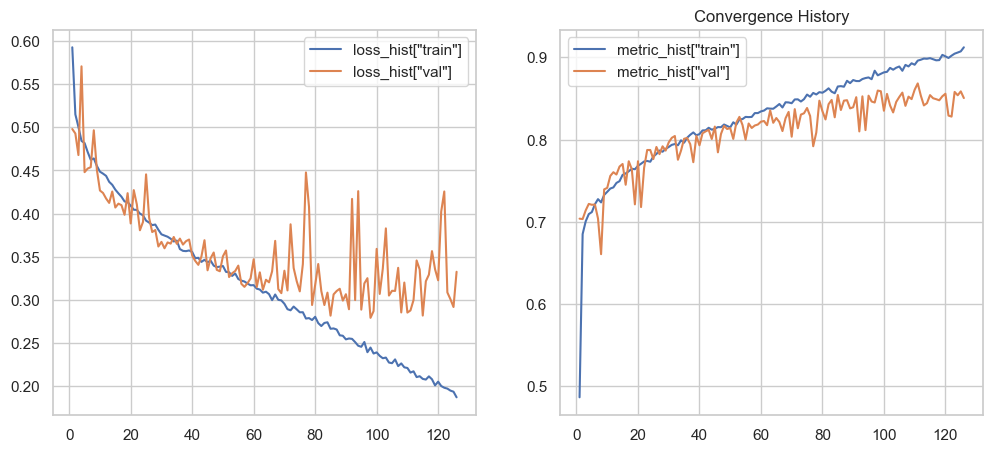

In [56]:
def reload_loss_metric_hist(models_folder, model_name):
    # Reload loss_hist and metric_hist from saved files
    with open(os.path.join(models_folder, f"loss_hist_{model_name}.pkl"), "rb") as f:
        loss_hist = pickle.load(f)
    with open(os.path.join(models_folder, f"metric_hist_{model_name}.pkl"), "rb") as f:
        metric_hist = pickle.load(f)
    return loss_hist, metric_hist


loss_hist, metric_hist = reload_loss_metric_hist(MODELS_FOLDER, best_model_name)

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(
    x=range(1, len(loss_hist["train"]) + 1),
    y=loss_hist["train"],
    ax=ax[0],
    label='loss_hist["train"]',
)
sns.lineplot(
    x=range(1, len(loss_hist["val"]) + 1),
    y=loss_hist["val"],
    ax=ax[0],
    label='loss_hist["val"]',
)
sns.lineplot(
    x=range(1, len(metric_hist["train"]) + 1),
    y=metric_hist["train"],
    ax=ax[1],
    label='metric_hist["train"]',
)
sns.lineplot(
    x=range(1, len(metric_hist["val"]) + 1),
    y=metric_hist["val"],
    ax=ax[1],
    label='metric_hist["val"]',
)
plt.title("Convergence History")

In [48]:
class pytorch_data(Dataset):
    def __init__(self, data_folder, labels_df, transforms, mode="test"):
        mode_data_folder = os.path.join(data_folder, mode)
        file_names = [f"{idx}.tif" for idx in labels_df["id"]]
        self.full_filenames = [os.path.join(mode_data_folder, f) for f in file_names]
        self.labels = (
            labels_df["label"].tolist()
            if "label" in labels_df.columns
            else [0] * len(labels_df)
        )
        self.transform = transforms

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]


# Running inference on the test set
test_ts = pytorch_data(DATA_FOLDER, test_df, data_transformer, mode="test")
test_dl = DataLoader(test_ts, batch_size=BATCH_SIZE, shuffle=False)


In [54]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run inference and collect predictions
all_preds = []
probs_np = []
with torch.no_grad():
    for images, _ in test_dl:
        images = images.to(device)
        outputs = cnn_model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        probs_np.extend(probs[:, 1].cpu().numpy())  # Probability for class 1

# ---- Print test outcome if labels available ----
if "label" in test_df.columns:
    labels_np = np.asarray(test_df["label"].values).astype(int).ravel()
    y_pred = np.asarray(all_preds).astype(int).ravel()
    probs_np_arr = np.asarray(probs_np)
    if probs_np_arr.shape[0] == labels_np.shape[0]:
        f1 = f1_score(labels_np, y_pred)
        prec = precision_score(labels_np, y_pred, zero_division=0)
        rec = recall_score(labels_np, y_pred, zero_division=0)
        pr_auc = average_precision_score(labels_np, probs_np_arr)
        print(
            f"Test F1: {f1:.5f} | Precision: {prec:.5f} | Recall: {rec:.5f} | PR-AUC: {pr_auc:.5f}"
        )
    else:
        print(
            f"Warning: label/score length mismatch: {labels_np.shape} vs {probs_np_arr.shape}"
        )


Test F1: 0.87472 | Precision: 0.87570 | Recall: 0.87374 | PR-AUC: 0.93852


In [55]:
# 1) Submission-style file (binary labels)
sub_df = test_df[["id"]].copy()
sub_df["label"] = all_preds
sub_path = os.path.join(
    DATA_FOLDER,
    "test_predictions_cnn.csv",
)
sub_df.to_csv(sub_path, index=False)
print("Saved:", sub_path)

# 2) Probabilities file (keep for analysis or if platform accepts probs)
sub_prob = test_df[["id"]].copy()
sub_prob["prob"] = np.array(probs_np).astype(float)
sub_prob_path = os.path.join(DATA_FOLDER, "test_probs_cnn.csv")
sub_prob.to_csv(sub_prob_path, index=False)
print("Saved:", sub_prob_path)


Saved: D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\test_predictions_cnn.csv
Saved: D:\OneDrive - fpts.com.vn\DucNN privates\Files\Khoa học dữ liệu\Chuyen_de_4_Hoc_sau_va_ung_dung_trong_bai_toan_anh\data\prepared_data\test_probs_cnn.csv
